# Imports

In [12]:
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Any, Callable, Optional, Union
from IPython.display import display, Image, HTML

import pygraphviz as pgv
import base64
import sympy as sm
from sympy.logic import SOPform
from sympy.core.symbol import Symbol
from sympy.logic.boolalg import BooleanFunction, Boolean, BooleanTrue, BooleanFalse
from sympy.printing.dot import dotprint, srepr
from sympy.printing.latex import LatexPrinter, print_latex

In [13]:
# sm.init_session(use_latex=False)''

In [14]:
def draw(
    *graphs: pgv.AGraph,
    width=200,
    labels=None,
    prog='dot'
):
    """https://stackoverflow.com/a/40494608 and DeepSeek"""

    html_content = "<div style = 'display: flex; flex-wrap: wrap; gap: 20px;'>"
    labels = labels or list(range(len(graphs)))
    for i, graph in enumerate(graphs):
        if not isinstance(graph, pgv.AGraph):
            raise Exception("I need graph!")
        img_b64 = base64.b64encode(
            graph.draw(format='png', prog=prog)
        ).decode()
        img_src = f"data:image/png;base64,{img_b64}"
        html_content += f"""
<div style = 'text-align: center;'>
    <img src = '{img_src}' width = '{width}' style = 'border: 1px solid #ccc;'>
    <div><strong>{labels[i]}</strong></div>
</div>
"""
    html_content += "</div>"
    display(HTML(html_content))

# Classes

In [24]:
@dataclass
class TreeNode:
    expression: Boolean
    children: tuple['TreeNode'] = tuple()
    pseudo_children: tuple['TreeNode'] = tuple()
    _closest_argument: Optional[Symbol] = None

    @property
    def closest_argument(self):
        if self._closest_argument is None:
            if self.is_final:
                self._closest_argument = self.expression
            temp: dict[Symbol, int] = dict()
            args = list(map(lambda x: (x, 0), self.expression.args))
            for arg, num in args:
                if isinstance(arg, Symbol):
                    prev_num = temp.get(arg, num)
                    temp[arg] = min(num, prev_num)
                else:
                    for a in arg.args:
                        args.append((a, num+1))
            self._closest_argument = min(temp.items(), key=lambda x: x[1])[0]
        return self._closest_argument

    def compute(self):
        if not self.is_final:
            symbol = self.closest_argument
            self.pseudo_children = \
                TreeNode(self.expression.subs(symbol, Symbol('0'))), \
                TreeNode(self.expression.subs(symbol, Symbol('1')))
            self.children = \
                TreeNode(self.expression.subs(symbol, 0)), \
                TreeNode(self.expression.subs(symbol, 1))
            for node in self.children:
                node.compute()

    def draw(self, graph: pgv.AGraph):
        if self.is_final:
            label = int(bool(self.expression))
            graph.add_node(id(self), shape='doublecircle', label=str(label))
            return
        label = '{%s | %s}' % (
            sm.pretty(self.expression).replace('∧', '&amp;').replace('∨', 'v'),
            self.closest_argument
        )
        graph.add_node(id(self), shape='record', label=label)
        for i, (node, fake) in enumerate(zip(self.children,
                                           self.pseudo_children)):
            graph.add_node(
                id(fake), shape='record',
                label=sm.pretty(fake.expression)
                .replace('∧', '&amp;').replace('∨', 'v')
            )
            graph.add_edge(id(self), id(fake), label=str(i))
            graph.add_edge(id(fake), id(node))
            node.draw(graph)

    def return_all_leaves(self, acc: set[Symbol]):
        if self.is_final:
            acc.add(self.expression)
            return acc
        for node in self.children:
            node.return_all_leaves(acc)
        return acc

    @property
    def is_final(self) -> bool:
        return isinstance(self.expression, Symbol | BooleanFalse | BooleanTrue)

In [25]:
@dataclass
class TreeMethod:
    init_expression: Boolean
    node: Optional[TreeNode] = None

    def restart(self):
        self.node = TreeNode(self.init_expression)

    def draw(self) -> pgv.AGraph:
        self.restart()
        self.node.compute()
        graph = pgv.AGraph(strict=False, directed=True)
        self.node.draw(graph)
        return graph

    def is_constant(self) -> bool:
        return len(self.node.return_all_leaves(set())) == 1 \
            if self.node else None

# Other

Выражение:
(B ∨ ¬A) → (D ∧ ¬C) = ¬((A → B) ∧ (C ∨ ¬D))
True



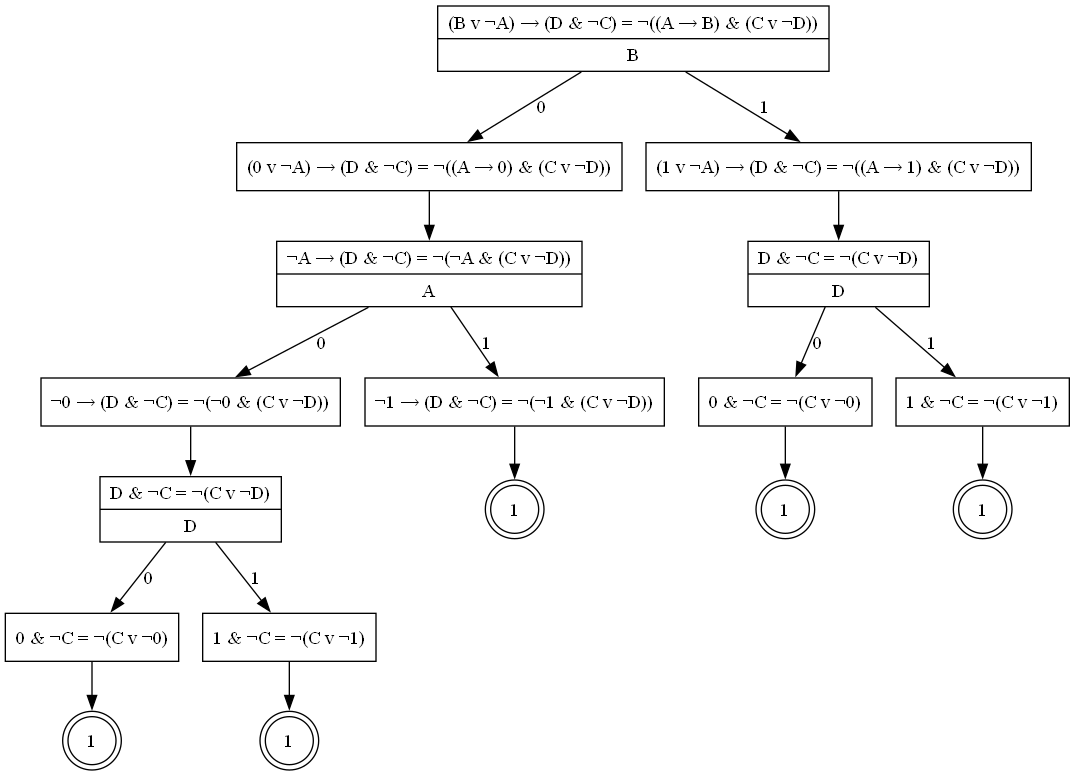

Как видно, это выражение - константное


In [28]:
x1, x2, x3, x4, _0, _1, A, B, C, D = sm.symbols('x1 x2 x3 x4 0 1 A B C D')
# expr = ((x1 | x2) & (~x1 | x3)) >> (x2 | x3)
expr = sm.Eq((~A | B) >> (~C & D), ~((A >> B) & (C | ~D)))
tree = TreeMethod(expr)
tree.restart()
print("Выражение:")
print(sm.pretty(tree.node.expression))
print(sm.pretty(tree.node.expression.simplify()))
graph = tree.draw()
draw(graph, width=800)
if tree.is_constant():
    print("Как видно, это выражение - константное")
else:
    print("Как видно, это выражение - не константное")